In [11]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from ipynb.fs.defs.Prepare_Data import train_test_val
from ipynb.fs.defs.Prepare_Data import load_csv_into_df
from ipynb.fs.defs.Prepare_Data import combine_dataframes
from ipynb.fs.defs.Feature_Engineering import preprocess_dataset
from ipynb.fs.defs.Data_Augmentation import data_augmentation
from config import lgbm_params
from config import lgbm_hyperparameter as lgbm_hp
import pandas as pd
import random
import matplotlib.pyplot as plt
from ipynb.fs.defs.Prepare_Data import train_test_val_kfold
from sklearn.model_selection import KFold

In [3]:
def get_vocabulary(column):
    text = ' '.join(column.astype(str))
    words = text.upper().split()
    word_counts = pd.Series(words).value_counts()
    vocabulary = word_counts.index.tolist()

    return vocabulary

In [4]:
def store_predictions(model, X_test, y_test, y_pred, features, timestamp):
    vectorizer_path = f"../models/lgbm_{timestamp}/vectorizer.pkl"
    # Load the vectorizer from the file
    with open(vectorizer_path, 'rb') as f:
        vectorizer = pickle.load(f)

    vocabulary_path = f"../models/lgbm_{timestamp}/vocabulary.pkl"
    # Get the vocabulary of the training data
    with open(vocabulary_path, 'rb') as f:
        vocabulary = pickle.load(f)
        
    
    probabilities = model.predict_proba(X_test)

    # Extrahieren der wichtigsten Features
    boost = model.booster_
    importance = boost.feature_importance()
    feature_names = boost.feature_name()
    sorted_idx = np.argsort(importance)[::-1]

    feature_dict = {vocabulary.shape[0]+index: key for index, key in enumerate(features)}

    true_label = y_test.reset_index(drop=True)

    X_test_restored = vectorizer.inverse_transform(X_test[:,:vocabulary.shape[0]-len(features)])
    original_designation = [' '.join(words) for words in X_test_restored]

    # Ausgabe der Vorhersagen, der Wahrscheinlichkeiten und der wichtigsten Features
    for i in range(len(X_test)):
        print('Vorhersage für Sample {}: {}'.format(i+1, y_pred[i]), 'True: {}'.format(true_label[i]))
        print(original_designation[i])

        print('Wahrscheinlichkeit für Sample {}: {}'.format(i+1, probabilities[i][1]))
        if y_pred[i] != true_label[i]:
            print('Wichtigste Features für Sample {}:'.format(i+1))
            for j in sorted_idx:
                if importance[j] > 0:
                    if j < vocabulary.shape[0]:
                        print('{} ({}) Value: {}'.format(feature_names[j], importance[j], vocabulary[j]))
                    else:
                        print('{} ({}) Value: {}'.format(feature_names[j], importance[j], feature_dict[j]))
                else:
                    continue
        print('------------------------')

In [5]:
def load_prepare_dataset(folder_path, augmentation, kfold):
    dataframes_list = load_csv_into_df(folder_path, original_prisma_data=False, move_to_archive=False)

    # Take random dataset from list as test set and drop it from the list
    random_index = random.randint(0, len(dataframes_list) - 1)
    df_test = dataframes_list[random_index]
    dataframes_list.pop(random_index)

    df_combined = combine_dataframes(dataframes_list)
    df_preprocessed, df_for_plot = preprocess_dataset(df_combined, cut_percent_of_front=lgbm_params["cut_percent_of_front"])
    df_test, df_test_for_plot = preprocess_dataset(df_test, cut_percent_of_front=lgbm_params["cut_percent_of_front"])

    vocab = get_vocabulary(df_preprocessed['Benennung (dt)'])

    if augmentation:
        # Declare which data augmentation techniques should be used
        rand_order = True
        rand_mistakes = True
        gpt = True

        # Generate the new dataset
        df_preprocessed = data_augmentation(df_preprocessed, rand_order, rand_mistakes, gpt, df_to_excel = False)

    weight_factor = round(df_preprocessed[df_preprocessed["Relevant fuer Messung"]=="Nein"].shape[0] / df_preprocessed[df_preprocessed["Relevant fuer Messung"]=="Ja"].shape[0])

    dateTimeObj = datetime.now()
    timestamp = dateTimeObj.strftime("%d%m%Y_%H%M")

    # Split dataset
    if kfold:
        X, y, X_test, y_test, features = train_test_val_kfold(df_preprocessed, df_test, test_size=lgbm_params["test_size"], timestamp=timestamp)
        return X, y, X_test, y_test, features, weight_factor, timestamp, vocab
    else:
        X_train, y_train, X_val, y_val, X_test, y_test, features = train_test_val(df_preprocessed, df_test, test_size=lgbm_params["test_size"], timestamp=timestamp)
        return X_train, y_train, X_val, y_val, X_test, y_test, features, weight_factor, timestamp, vocab

In [6]:
def train_model(X_train, y_train, X_val, y_val, weight_factor):
    
    class_weight = {0: 1, 1: weight_factor}
    evals = {}
    callbacks = [lgb.early_stopping(lgbm_params["early_stopping"]), lgb.record_evaluation(evals)]

    gbm = LGBMClassifier(objective='binary',
                        metric=lgbm_params["metrics"],
                        num_leaves=lgbm_hp["num_leaves"],
                        max_depth=lgbm_hp["max_depth"],
                        learning_rate=lgbm_hp["lr"],
                        feature_fraction=lgbm_hp["feature_fraction"],
                        n_estimators=lgbm_params["n_estimators"],
                        class_weight=class_weight)

    gbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric=lgbm_params["metrics"],
            early_stopping_rounds=lgbm_params["early_stopping"],
            callbacks=callbacks)

    
    return gbm, evals

In [7]:
def store_trained_model(model, test_acc, timestamp):
    # save model
    model_path = f"../models/lgbm_{timestamp}/model_{str(test_acc)[2:]}.pkl"
    with open(model_path, "wb") as filestore:
        pickle.dump(model, filestore)

In [8]:
def evaluate_model(model, X_test, y_test, evals, timestamp):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)

    # Print accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print("\n\n Test accuracy:", accuracy, "\n\n")

    lgb.plot_metric(evals, metric='binary_logloss')
    plt.savefig(f'../models/lgbm_{timestamp}/binary_logloss_plot.png')

    lgb.plot_metric(evals, metric='auc')
    plt.savefig(f'../models/lgbm_{timestamp}/auc_plot.png')

    class_names = ["Nein", "Ja"]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues', colorbar=False)
    plt.savefig(f'../models/lgbm_{timestamp}/confusion_matrix.png')

    return y_pred, accuracy

2023-05-16 15:54:20.480 | INFO     | ipynb.fs.defs.Prepare_Data:load_csv_into_df:34 - Loading the data...
2023-05-16 15:54:35.532 | SUCCESS  | ipynb.fs.defs.Prepare_Data:load_csv_into_df:68 - 8 dataframe(s) were created.
2023-05-16 15:55:13.297 | SUCCESS  | ipynb.fs.defs.Prepare_Data:combine_dataframes:91 - 7 dataframe(s) are combined to one dataset and stored in a excel file.
2023-05-16 15:55:13.299 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 20189 samples...
2023-05-16 15:55:40.963 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The new dataset contains 3394 samples
2023-05-16 15:55:40.966 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 3576 samples...
2023-05-16 15:55:46.194 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.9398625429553265 


Vorhersage für Sample 1: 0 True: 0
 mo  mot  moto  motor  motort  motortr aeg aege aeger aer aerk aerku aerkun aerkung aerkung  ash ashv ashve ashver ashvers ashverst cra cras crash crashv crashve crashver ege eger erk erku erkun erkung erkung  erkung m ers erst ersta erstae erstaer erstaerk g m g mo g mot g moto g motor g motort ger hve hver hvers hverst hversta hverstae kun kung kung  kung m kung mo kung mot mot moto motor motort motortr motortra ng  ng m ng mo ng mot ng moto ng motor ort ortr ortra ortrae ortraeg ortraege oto otor otort otortr otortra otortrae rae raeg raege raeger ras rash rashv rashve rashver rashvers rku rkun rkung rkung  rkung m rkung mo rst rsta rstae rstaer rstaerk rstaerku rtr rtra rtrae rtraeg rtraege rtraeger shv shve shver shvers shver

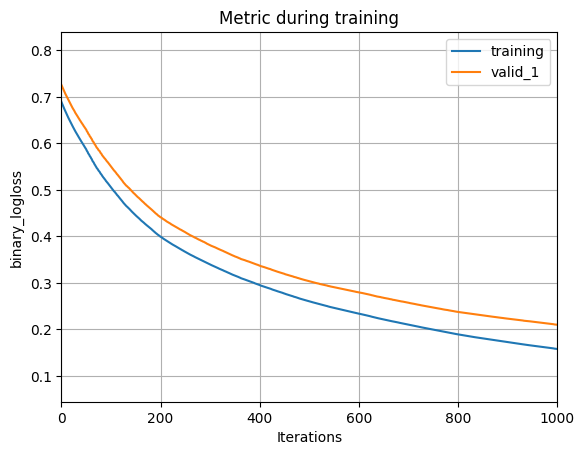

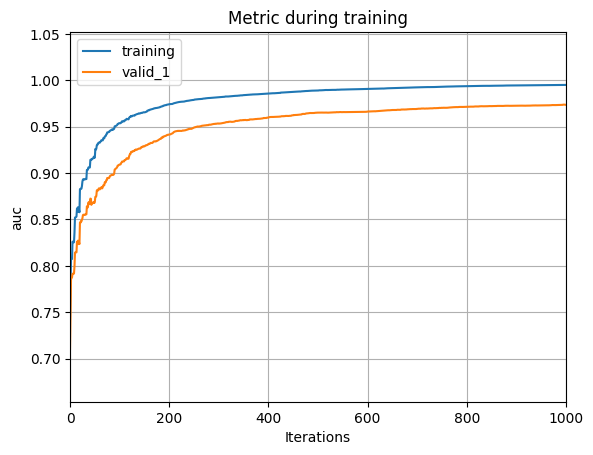

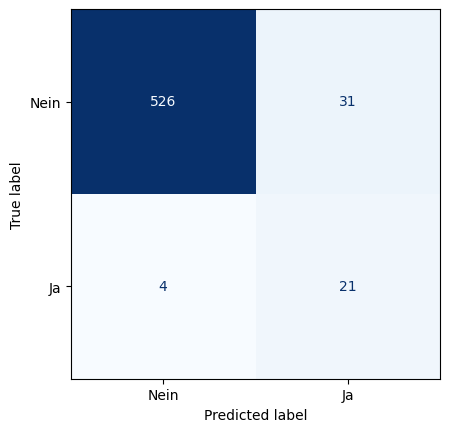

In [29]:
# Split dataset
folder_path = "../data/labeled_data/"
store_model = True
show_preds = True

X_train, y_train, X_val, y_val, X_test, y_test, features, weight_factor, timestamp, vocab = load_prepare_dataset(folder_path, augmentation=True, kfold=False)

gbm, evals = train_model(X_train, y_train, X_val, y_val, weight_factor)
y_pred, test_acc = evaluate_model(gbm, X_test, y_test, evals, timestamp)

if show_preds:
    store_predictions(gbm, X_test, y_test, y_pred, features, timestamp)

if store_model:
    store_trained_model(gbm, test_acc, timestamp)


2023-05-16 16:22:10.666 | INFO     | ipynb.fs.defs.Prepare_Data:load_csv_into_df:34 - Loading the data...
2023-05-16 16:22:17.107 | SUCCESS  | ipynb.fs.defs.Prepare_Data:load_csv_into_df:67 - 8 dataframe(s) were created.
2023-05-16 16:22:36.263 | SUCCESS  | ipynb.fs.defs.Prepare_Data:combine_dataframes:90 - 7 dataframe(s) are combined to one dataset and stored in a excel file.
2023-05-16 16:22:36.265 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 20715 samples...
2023-05-16 16:22:50.833 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The new dataset contains 3523 samples
2023-05-16 16:22:50.835 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 3050 samples...
2023-05-16 16:22:53.061 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.968 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.986 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.974 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.954 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[92]	training's auc: 0.952744	training's binary_logloss: 0.516879	valid_1's auc: 0.916388	valid_1's binary_logloss: 0.545903


 Test accuracy: 0.942 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.974 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.974 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


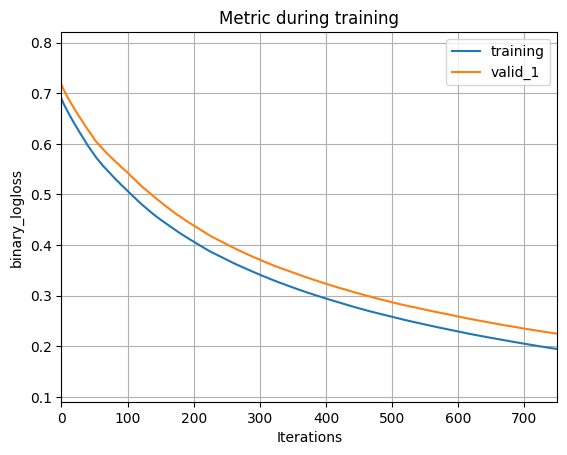

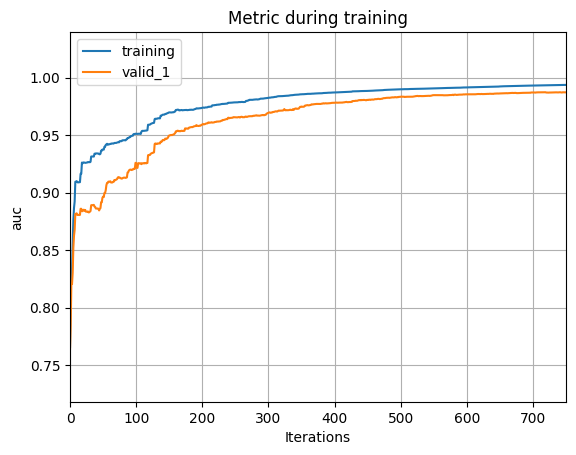

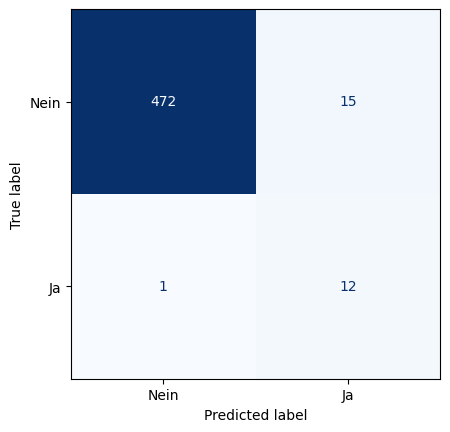

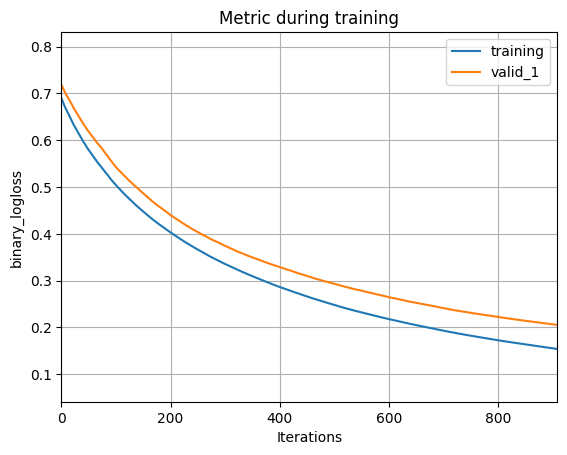

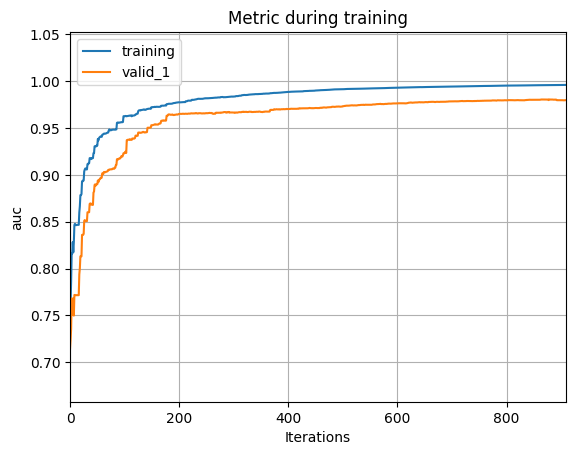

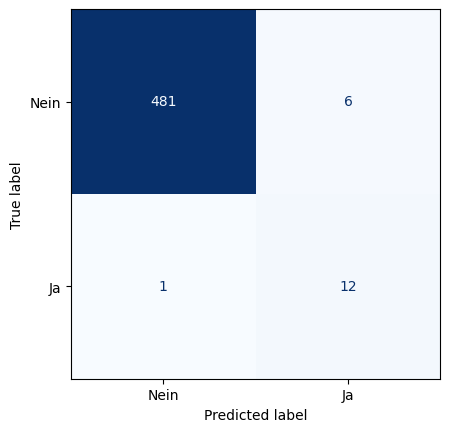

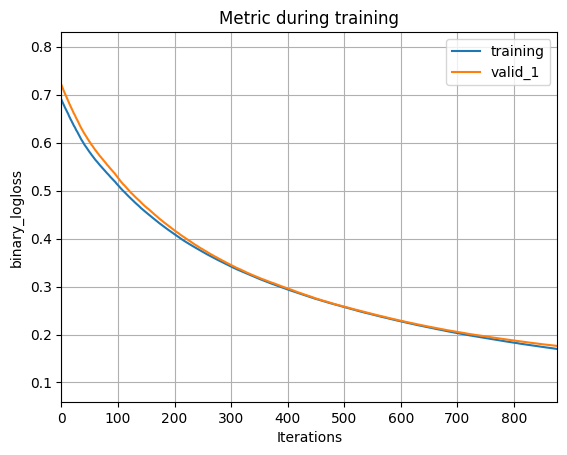

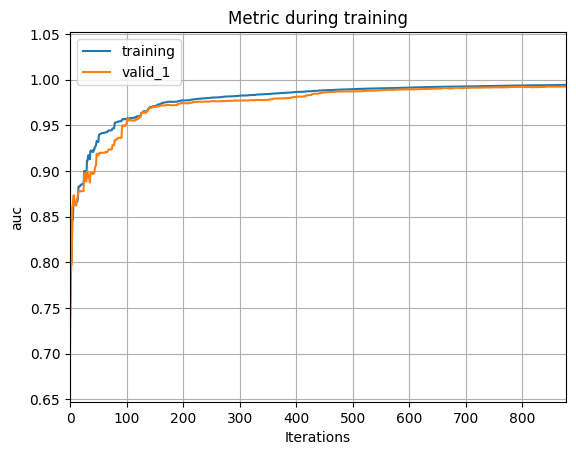

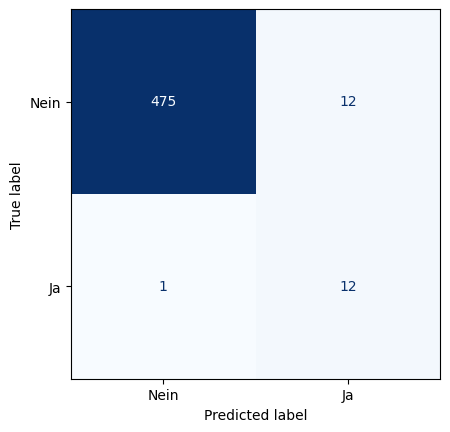

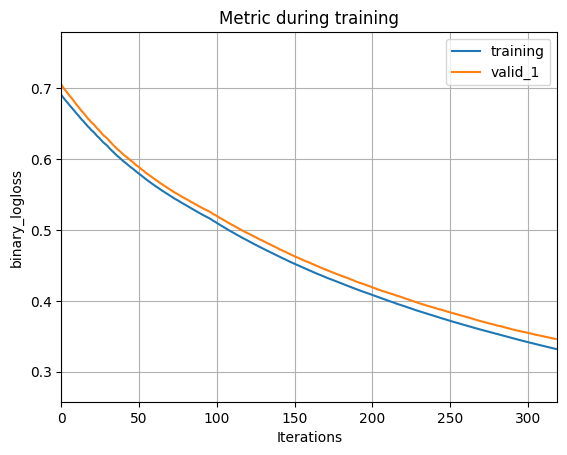

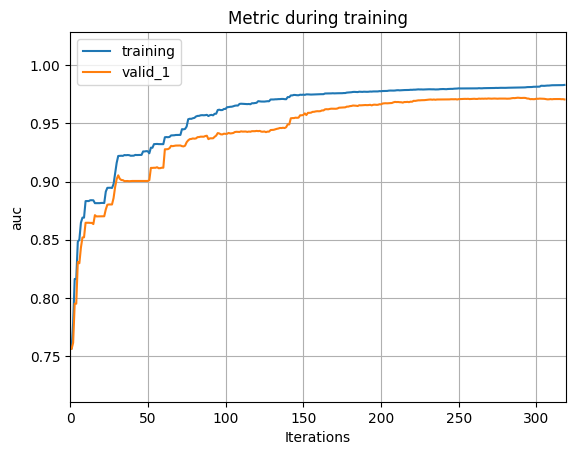

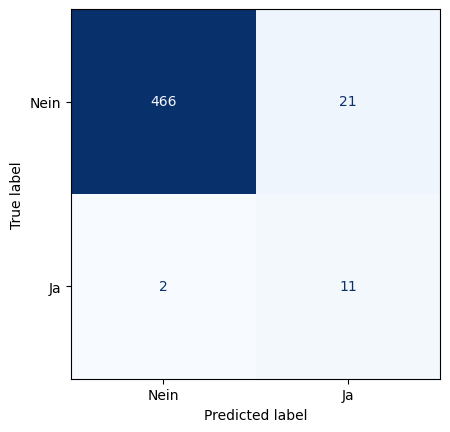

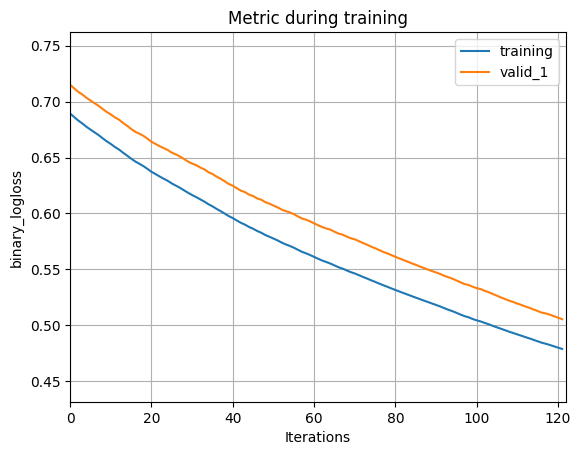

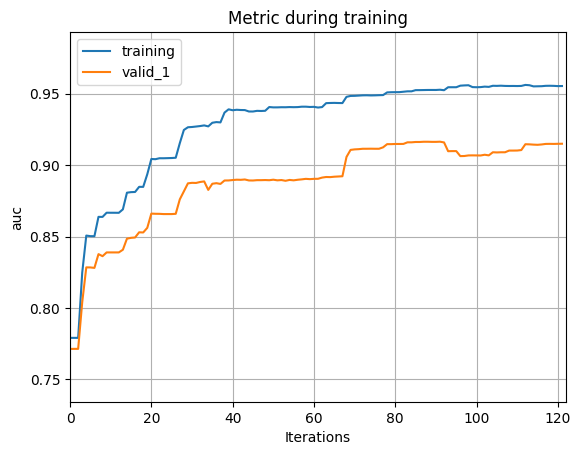

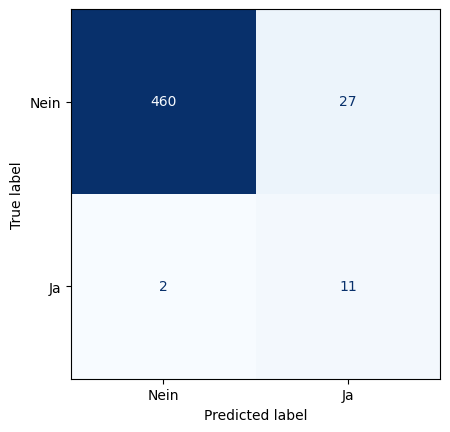

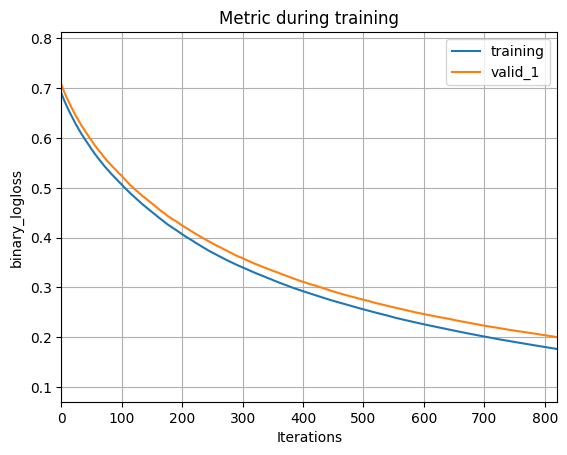

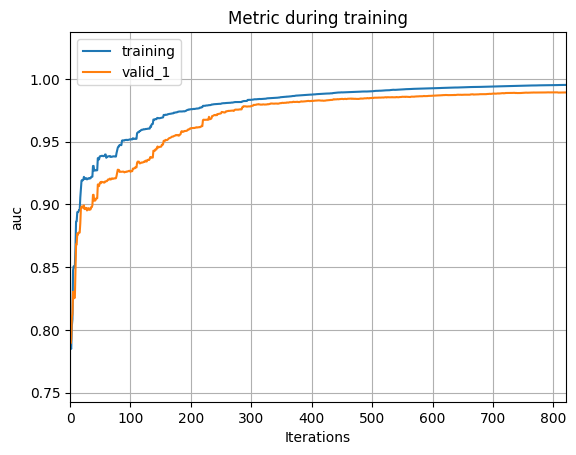

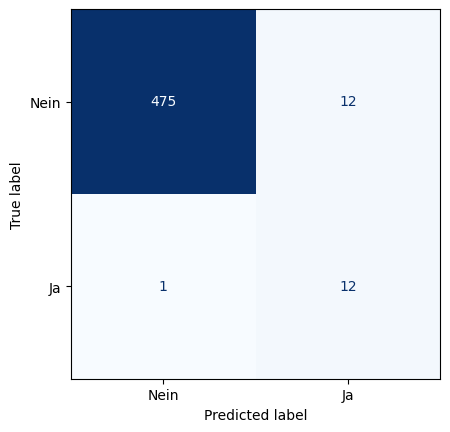

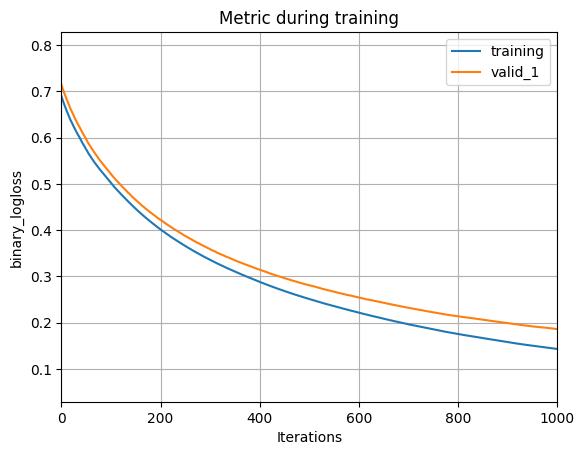

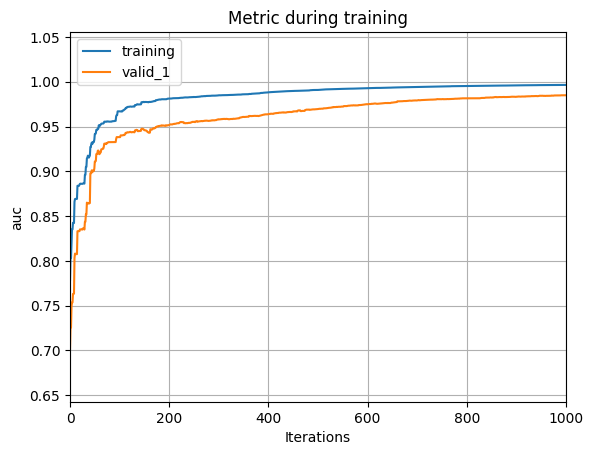

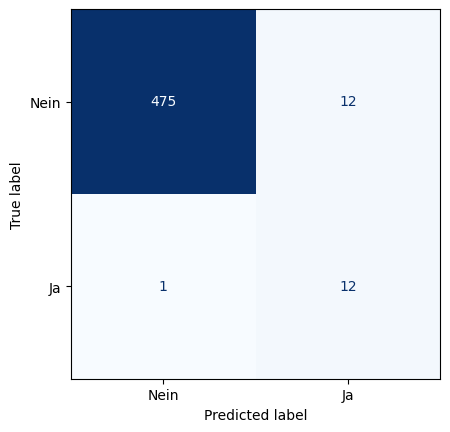

In [14]:
# Split dataset
folder_path = "../data/labeled_data/"
store_model = False
show_preds = False

X_train, y_train, X_test, y_test, features, weight_factor, timestamp, vocab = load_prepare_dataset(folder_path, augmentation=True, kfold=True)

kfold = KFold(n_splits=7, shuffle=True, random_state=42)
evals_list = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    gbm, evals = train_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold, weight_factor)
    evals_list.append(evals)

    y_pred, test_acc = evaluate_model(gbm, X_test, y_test, evals, timestamp)

if show_preds:
    store_predictions(gbm, X_test, y_test, y_pred, features, timestamp)

if store_model:
    store_trained_model(gbm, test_acc, timestamp)